![figure 0](rsc/teaser.png)

# Reproducing 'Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network'

In this notebook, we reproduce the fourth column of Table 1 from the paper [**Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network**](https://arxiv.org/pdf/1609.05158v2.pdf). The code has been created following the paper with gaps 
filled in by ourselves.
The paper presents a convolutional neural network capable of real-time Super-Resolution (SR).
They designed a CNN architecture where the feature maps are extracted in the Low-Resolution(LR) space 
and introducing an efficient sub-pixel convolution layer which learns an array of upscaling filters to upscale
the final LR feature maps into the High-Resolution(HR) output.
A researcher would like a reproduction of this to test on his high-res dataset.


---
### ESPCN
For the problem of single image super-resolution (SISR), the authors of this paper set out to improve the network known as SRCN, discussed in [this paper](https://ieeexplore.ieee.org/abstract/document/7115171). SRCNN approaches the problem by increasing the resolution of the LR image before the first layer of the network. The authors argue this is inefficient since the processing speed of convolutional networks directly depends on the resolution of the input image. Therefore they propose a faster network called ESPCN.

The new architecture improves this by increasing the resolution from LR to HR only at the very end of the network and super-resolves HR data from LR feature maps, by first applying a multi-layer CNN directly to LR image and then applying a sub-pixel convolution layer that upscales the LR feature maps to produce the SR output image.  Figure 1 (retrieved from [the original paper](https://arxiv.org/pdf/1609.05158v2.pdf)) shows a visualisation of the network, the rest of this section is dedicated to the mathematical description of the network.

![figure 1](rsc/ESPCN.PNG)

For a network composed of L layers, $n_{L-1}$ upscaling filters for the $n_{L-1}$ feature maps are learned. The first L−1 layers can be described as follows:  
  
$f^1(\boldsymbol{I}^{LR};W_1, b_1)= \phi (W_1 \ast \boldsymbol{I}^{LR}+b_1)$  
$f^l(\boldsymbol{I}^{LR};W_{1:l}, b_{1:l})= \phi (W_1 \ast f^{l-1}(\boldsymbol{I}^{LR})+b_l)$  
  
Where $W_l , b_l , l \in (1, L - 1)$ are learnable network weights and biases respectively.  
  
$W_l$ is a 2D convolution tensor of size $n_{l-1} \times n_l \times k_l \times k_l$ , where $n_l$ is the number of 
features at layer $l$, $n_0 = C$, and $k_l$ is the filter size at layer $l$.  
The biases $b_l$ are vectors of length $n_l$ . The nonlinearity function (or activation function) $\phi$ is applied 
element-wise and is fixed. The last layer $f^L$ converts the LR feature maps to an HR image $\boldsymbol{I}^{SR}$.  
  
The last layer is an efficient sub-pixel convolution layer. The authors propose a convolution with stride $\frac{1}{r}$ in de LR space with a filter $W_s$ of size $k_s$ with a weight spacing $\frac{1}{r}$. This way, each activation pattern is periodically activated during the convolution of the filter depending on different sub-pixel locations. A way to implement this can be described in the following way:  
$\boldsymbol{I}^{SR}=f^L (\boldsymbol{I}^{LR}) = \mathcal{PS} (W_L \ast f^{L-1} (\boldsymbol{I}^{LR}) + b_L)$
  
Where $\mathcal{PS}$ is an periodic shuffling operator that rearranges the elements of a $H \times W \times C \cdot r^2$ tensor to a tensor of shape $rH \times rW \times C$. 
The periodic shuffle can be denoted as follows:
$\mathcal{PS} (T)_{x,y,c} = T_{\lfloor x/r \rfloor, \lfloor y/r \rfloor , C\cdot r \cdot mod(y,r) + C\cdot mod(x,r) + c}$.
The convolution operator $W_L$ thus has shape $n_{L - 1} \times C \cdot r^2 \times k_L \times k_L$. 

The proposed network can be referred to as an efficient sub-pixel convolutional neural network, also referred to as *ESPCN*. 

A pixel-wise mean squared error function is used to train the network:
$\ell(W_{1:L}, b_{1:L}) = \frac{1}{r^2HW}\sum^{rH}_{x=1}\sum^{rW}_{x=1} (\boldsymbol{I}^{HR}_{x,y} - f^L_{x,y}(\boldsymbol{I}^{LR}))^2$.  
  
To increase the performance while learning the periodic shuffling at the end can be avoided during training since the labelled training data can be inversely shuffled to match the output of the last layer before it is shuffled, therefore avoiding unnecessary calculations.

---

## Experiment Setup 

Reproducing the results consists of two main steps, namely:  
1. generating the training data
2. training the network on said data  

Both of these steps are discussed below individually.

### 1. Generating the training data
Since the T91 data set only consists of 91 images, the images need to be transformed in various ways to generate a sufficient amount of training data. Three steps are applied to the T91 data set in order to generate the training data.
1. A gaussian blur (sigma \= \[$0.1$ - $1$\]) is applied to the original images to simulate optical blur of a low-resolution camera and the images are downscaled by a factor $3$.
2. $17$ by $17$ training images are subsampled from the downscaled images, corresponding to $17r$ by $17r$ pixel subsamples of the original HR images
3. An inverse periodic shuffle is applied on the $17r$ by $17r$ pixel subsamples of original HR images to obtain training data labels

![figure 2](rsc/ss_hr_to_lr.png)

### 2. Training the network
Once the training data is generated we can begin training. The model is trained to predict the inverse shuffled HR subsamples from the corresponding blurred LR subsamples. To reproduce the original paper as accurately as possible, the exact implementation details from their paper were implemented. However, some of the information necessary for reproducing these results was missing. This missing information and our approach are detailed further in *Discussion*.  

### Results
From the losses shown in the figure below we can conclude that our network is able to learn on the generated data.

![figure 3](rsc/train_and_test_loss.png)

After training for approximately 3000 epochs, we achieved the results in the *Our ESPCN* column:

| Data Set | Scale | Bi-cubic | SRCNN (91)| Paper ESPCN | Our ESPCN |
|----------|-------|----------|-----------|-------------|-----------|
|Set5      | 3     | 27.53    | 32.39     | 32.55       | 32.25     |
|Set14     | 3     | 25.25    | 29.00     | 29.08       | 28.50     |
|BSD300    | 3     | 25.57    | 28.21     | 28.26       | 28.02     |
|BSD500    | 3     | 25.54    | 28.28     | 28.34       | 28.08     |

The results are similar to the *Paper ESPCN*, but since our model is not an improvement over *SRCNN* we do not feel that we were able to reproduce the results from the paper. The reason why we were unable to reproduce the results and our approach to optimizing our own results are discussed in *Discussion*.

---
## Discussion
We did not manage to reproduce the results from Table 1 from the [original paper](https://arxiv.org/pdf/1609.05158v2.pdf), column ESPCN (91). When trying to recreate the results of the paper, we recreated the model as described in the paper. However, some hyperparameters and architectural decisions were not given. The following information was missing from the paper and made it harder to reproduce the results:
* **Optimizer**: It is not stated what optimizer is used when training the network.
* **How the learning rate changes from high to low**: It is not stated how the learning rate changes between its start- and end-value. A parameter ‘mu’ is mentioned, where the learning rate decreases with an unknown amount when the improvement is smaller than ‘mu’. However, the value of ‘mu’ is not given.
* **Gaussian blur**: To simulate the downscale image when training in a realistic manner, the training images are blurred. However, the intensity of this blur is not given.

In order to find optimal values for these parameters, we export the values of these parameters and their respective results to a *.csv* file after each training session. This allowed us to easily run the training multiple times with different parameter sets and compare their respective results. Though we were able to optimize our network by finding better parameters, we were still unable to reproduce the results from the paper.

When implementing and training *ESPCN* we encountered a few other parameters that were not necessarily missing from the paper, but would have been beneficial to have more information on, namely:

* **Batch size**: The batch size was not given, nor was it clear from the paper whether batches were used at all. This information would have been useful to interpret their training times and compare them to ours.
* **Model validation**: The T91 dataset was used for training. However, it was not specified whether this dataset was split up into a train, test and validation set. Was (k-fold) cross-validation used, was some other validation method used or did they train on the full dataset without validation?

### Chosen parameters values
After experimenting with multiple runs these were the observations we made w.r.t. the impact and optimal values of the missing (hyper)parameters:

__Optimizer__: Adam is used instead of SGD as proposed in the paper. For SGD the results obtained with the high-level description in the paper were far below the results in the paper - SGD needs to be fine-tuned so it is important the paper should have mentioned the specific parameters and method. The adam optimizer works in a similar way but the only parameter to be set is the final learning rate which is set to $1e-4$ as in the paper. 

__Gaussian blur sigma__: values between $0$ and $2$ were tried for the gaussian sigma, with values between $0.25$ and $1$ showing similar performance, a sigma of $1$ achieved the highest performance which is used for our final reproduction model.

A __no-learning threshold__ of $1e-7$ is chosen meaning the training stops after $100$ epochs where the max improvement per epoch is below this threshold. Choosing a higher threshold causes the training process to end with suboptimal results and experiments run with a smaller threshold did not finish within a day.

A __batch size__ of $10$ was chosen to speed up training. Using lower batch sizes (below $4$) considerably increased the training time and much higher batch sizes (e.g. $50$, $100$) resulted in a higher loss while training.

A __train/test split__ is not mentioned by the paper, we tried splits $70$-$30$, $80$-$20$, $90$-$10$ with the $90$-$10$ split giving the best PSNR.

---
# The model
Below the complete code for creating the network and loading the data is discussed. The concepts used are


First, all dependencies are imported.

In [15]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import *
from skimage.transform import *
import os
import math
import csv

### Hyper parameters
Then all hyperparameters and parameters, as well as constants are set.

In [16]:
# CONSTANTS
C = 3 # amount of colour channels
dataset = "T91" # the folder containing all images used for training
epoch_save_interval = 100 # the interval after which an intermediate save is made
logging_interval = 100 # the interval after which we log the losses the the console
use_gpu = torch.cuda.is_available()

# HYPERPARAMETERS and PARAMETERS
r = 3  # upscaling ratio
blur = 1  # gaussian blur
adam_learning_rate = 1e-4 #adam learning rate, equal to paper's final learning rate
no_learning_threshold = 1e-8  # threshold for stopping training when no improvement has been made for 'repeats' epochs
repeats = 100 # the number of consecutive epochs without (enough) improvement necessary to stop training 
batch_size = 4 # size of batches
train_test_fraction = 0.9 # the fraction of the data that is used for training, the remainder is used as a test set

### Periodic Shuffle
In the code below the Periodic Shuffle and its inverse are defined as functions to be used when loading in the data.
As mentioned before, the Periodic Shuffle is defined as follows:
$\mathcal{PS} (T)_{x,y,c} = T_{\lfloor x/r \rfloor, \lfloor y/r \rfloor , C\cdot r \cdot mod(y,r) + C\cdot mod(x,r) + c}$

In [17]:
def PS(T, r):
    T = np.transpose(T, (1, 2, 0))
    rW = r * len(T)
    rH = r * len(T[0])
    C = len(T[0][0]) / (r * r)

    # make sure C is an integer and cast if this is the case
    assert (C == int(C))
    C = int(C)

    res = np.zeros((rW, rH, C))

    for x in range(len(res)):
        for y in range(len(res[x])):
            for c in range(len(res[x][y])):
                res[x][y][c] = \
                    T[x // r][y // r][C * r * (y % r) + C * (x % r) + c]
    return res


def PS_inv(img, r):
    r2 = r * r
    W = len(img) / r
    H = len(img[0]) / r
    C = len(img[0][0])
    Cr2 = C * r2

    # Make sure H and W are integers
    assert (int(H) == H and int(W) == W)
    H, W = int(H), int(W)

    res = np.zeros((W, H, Cr2))

    for x in range(len(img)):
        for y in range(len(img[x])):
            for c in range(len(img[x][y])):
                res[x // r][y // r][C * r * (y % r) + C * (x % r) + c] = img[x][y][c]
    return res

### Loading the data
The images from T91 are loaded in, then they are used to create a train and test set. This process is described under *Experiment Setup*.

Data loaded


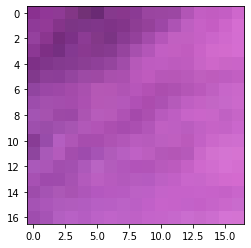

In [18]:
"""
Downsample images
- gaussian blur
- resize by downsample factor (using interpolation)
How To Use:
    function lr_dataset_from_path takes a path to the dataset of HR image png files and returns an ndarray to use for training the model
For debugging/showing examples:
    (see bottom of file)
    save_png set to True to save resulting lr images in specified directory.
    !check the param_ varaiables
"""

SUBSAMPLING_STRIDE_SIZE = 14
SUBSAMPLING_SAMPLE_SIZE = 17


# hr_dataset_path: dir to the hr_dataset png files
# downscale: downscale factor, e.g. if original image 64*64 and downscale=2 then result will be 32*32
# returns list of numpy.ndarray representing the lr_images
def lr_dataset_from_path(hr_dataset_path, downscale):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))
    return lr_images(original_images, downscale)  # ndarray of images


def torchDataloader_from_path(hr_dataset_path, downscale, gaussian_sigma, batch_size):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))

    # subsample
    subsamples_hr = []
    subsamples_hr_rev_shuff = []
    for i in range(len(original_images)):
        temp_subsamples = subsample(original_images[i], downscale)
        subsamples_hr += temp_subsamples
        for sample_indx in range(len(temp_subsamples)):
            subsamples_hr_rev_shuff.append(PS_inv(temp_subsamples[sample_indx], downscale))  # labels
    lr_dataset = lr_images(subsamples_hr, downscale, gaussian_sigma)  # ndarray of images
    return toDataloader(lr_dataset, subsamples_hr_rev_shuff, batch_size=batch_size)


# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real, downscale, gaussianSigma):
    lr_images = []
    for img in range(len(images_real)):
        img_blurred = gaussian(images_real[img], sigma=gaussianSigma,
                               multichannel=True)  # multichannel blurr so that 3rd channel is not blurred
        lr_images.append(resize(img_blurred, (img_blurred.shape[0] // downscale, img_blurred.shape[1] // downscale)))
    return lr_images


# extract a 17r*17r subsample from original image, no overlap so every pixel appears at most once in output
def subsample(image_real, downscale):
    subsample_size = SUBSAMPLING_SAMPLE_SIZE * downscale
    subsample_stride = SUBSAMPLING_STRIDE_SIZE * downscale
    subsamples = []
    for y in range(math.floor((image_real.shape[0] - (subsample_size - subsample_stride)) / subsample_stride)):
        for x in range(math.floor((image_real.shape[1] - (subsample_size - subsample_stride)) / subsample_stride)):
            ss = image_real[(y * subsample_stride):(y * subsample_stride) + subsample_size,
                 (x * subsample_stride):(x * subsample_stride) + subsample_size]
            subsamples.append(ss)

    return subsamples


# returns a torch Dataloader (to iterate over training data) using the training data samples and traing data labels
def toDataloader(train_data, train_labels, batch_size):
    labeled_data = []
    for i in range(len(train_data)):
        labeled_data.append([np.transpose(train_data[i], (2, 0, 1)), np.transpose(train_labels[i], (2, 0, 1))])
    trainDataloader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
    return trainDataloader

# Load the data
dataloader = torchDataloader_from_path('./datasets/' + dataset, r, blur, batch_size)
train_size = int(train_test_fraction * len(dataloader.dataset))
test_size = len(dataloader.dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataloader.dataset, [train_size, test_size])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
print("Data loaded")

# show first image from the dat
plt.imshow(np.transpose(dataloader.dataset[0][0], (1, 2, 0)))
plt.show()

### The Network
A CNN is defined with 3 layers. The first layer takes in the coloured image (C = 3). This layer has 64 feature maps with a kernel size of 5. The second layer has 32 feature maps with a kernel size of 3. The last layer has C($r^2$) feature maps with a kernel size of 3.

In [19]:
class Net(nn.Module):
    def __init__(self, r, C):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(C, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, r * r * C, 3, padding=1)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = self.conv3(x)
        return x


### The Training
In the following code, the network is trained. During this training the losses, some models and the best model are saved. On intervals, the current progress is logged also to the console.

In [ ]:
# Start training and saving the start time
start_time = datetime.datetime.now()
print("starting training at: " + str(start_time))

# initialize the ESPCN
net = Net(r, C)
net.double()

if use_gpu:
    net = net.cuda()

# define loss fuction
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=adam_learning_rate) #adam optimizer, less sensitive to hyperparams

losses_train = []
losses_test = []

epoch = 0
last_epoch_loss_test = float("inf")
last_epoch_loss_train = float("inf")
ni_counter = 0  # counts the amount of epochs no where no improvement has been made

# creating a new folder for saving the models and losses
dt_string = start_time.strftime("%Y-%m-%d_%H-%M-%S")
models_folder = "models"
model_name = "{}_espcnn_r{}".format(dt_string, r)

try:
    os.mkdir(models_folder + '/' + model_name)
except:
    print("Folder {} already exists, overwritting model data".format(models_folder + '/' + model_name))
model_dest = models_folder + '/' + model_name + "/model_epoch_"
best_model_dest = models_folder + '/' + model_name + "/best_model"



best_test_loss = float("inf")  # start with dummy value, keep track of best loss on test dataset
best_epoch = 0
try:
    while True:  # loop over the dataset multiple times
        epoch_loss_train = 0.0
        running_loss_train = 0.0
        for i, data in enumerate(train_dataloader, 0): # loop through the training data
            # get the inputs
            inputs, labels = data
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.double())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_loss_train += outputs.shape[0] * loss.item()
            running_loss_train += loss.item()
            if i % logging_interval == logging_interval - 1:
                print('[%d, %5d] train_loss: %.5f' %
                      (epoch + 1, i + 1, running_loss_train / logging_interval))
                running_loss_train = 0.0
        epoch_loss_train = epoch_loss_train / len(train_dataloader.dataset)
        print(epoch + 1, epoch_loss_train)

        epoch_loss_test = 0.0
        running_loss_test = 0.0
        for i, data in enumerate(test_dataloader, 0):  # loop through the test data and calculate the test error
            # get the inputs
            inputs, labels = data
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward + backward + optimize
            outputs = net(inputs.double())
            loss = criterion(outputs, labels)

            # print statistics
            epoch_loss_test += outputs.shape[0] * loss.item()
            running_loss_test += loss.item()
            if i % logging_interval == logging_interval - 1:
                print('[%d, %5d] test_loss: %.5f' %
                      (epoch + 1, i + 1, running_loss_test / logging_interval))
                running_loss_test = 0.0
        epoch_loss_test = epoch_loss_test / len(test_dataloader.dataset)
        print(epoch + 1, epoch_loss_test)

        # Calculating the improvement
        improvement = best_test_loss - epoch_loss_test

        if epoch_loss_test < best_test_loss:  # save best model, 'best' meaning lowest loss on test set
            best_test_loss = epoch_loss_test
            torch.save(net.state_dict(),
                       best_model_dest)  # overwrite best model so the best model filename doesn't change
            best_epoch = epoch
            best_epoch_train_loss = epoch_loss_train

        # stop training if no improvement has been made for 'repeats' epochs
        print("epoch " + str(epoch + 1) + ": improvement = " + str(improvement))
        if improvement < no_learning_threshold:
            ni_counter += 1
        else:
            ni_counter = 0

        if ni_counter >= repeats:
            break

        # save losses
        losses_train.append(epoch_loss_train)
        losses_test.append(epoch_loss_test)
        last_epoch_loss_train = epoch_loss_train
        last_epoch_loss_test = epoch_loss_test

        # every 'epch_save_interval' save the current model
        if epoch % epoch_save_interval == 0:
            torch.save(net.state_dict(), model_dest + str(epoch + 1))
        epoch += 1
except KeyboardInterrupt: # this allows for manually stopping the training without losing the progress
    print("Press Ctrl-C to terminate while statement")
    pass

    print('Saving train and test loss')
    np.save(models_folder + '/' + model_name + '/loss_train', losses_train)
    np.save(models_folder + '/' + model_name + '/loss_test', losses_test)

# Show training duration
end_time = datetime.datetime.now()
print('Finished training at: ' + str(end_time))

starting training at: 2020-04-15 13:36:51.793167
[1,   100] train_loss: 0.09192
[1,   200] train_loss: 0.03460
[1,   300] train_loss: 0.02375
[1,   400] train_loss: 0.01626
[1,   500] train_loss: 0.01319
1 0.03391371858653152
1 0.011432795600525587
epoch 1: improvement = inf

[......]
[325,   100] train_loss: 0.00176
[325,   200] train_loss: 0.00216
[325,   300] train_loss: 0.00195
[325,   400] train_loss: 0.00195
[325,   500] train_loss: 0.00212
325 0.001968356708164576
325 0.0019475461612997011
epoch 325: improvement = -5.3183129018498625e-06


### PSNR
Define PSNR (Peak Signal to Noise Ratio) in order to validate the model.

In [23]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if (mse == 0):  # MSE is zero means no noise is present in the signal .
        # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr


def average_PSNR(folder, net, r, gaussianSigma):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder, filename))
        if img is not None:
            img = resize(img, ((img.shape[0] // r) * r, (img.shape[1] // r) * r))
            images.append(img)

    sumPSNR = 0
    for og_img in images:
        img_blurred = gaussian(og_img, sigma=gaussianSigma,
                               multichannel=True)  # multichannel blurr so that 3rd channel is not blurred
        img = resize(img_blurred, (img_blurred.shape[0] // r, img_blurred.shape[1] // r))
        if (len(img.shape) == 2):  # convert image to rgb if it is grayscale
            img = np.stack((img, img, img), axis=2)
            og_img = np.stack((og_img, og_img, og_img), axis=2)
        img = np.transpose(img, (2, 0, 1))
        img = torch.Tensor(img).unsqueeze(0).double()
        result = net(img).detach().numpy()
        sumPSNR += PSNR(PS(result[0], r) * 255, og_img * 255)

    return sumPSNR / len(images)

### Logging and saving results
Printing and saving the settings and results to console and CSV.

In [24]:
print('Saving train and test loss')
np.save(models_folder + '/' + model_name + '/loss_train', losses_train)
np.save(models_folder + '/' + model_name + '/loss_test', losses_test)

net.load_state_dict(torch.load(best_model_dest))
net.eval()

net.cpu()
set5_PSNR = average_PSNR("./datasets/testing/Set5", net, r, blur)
set14_PSNR = average_PSNR("./datasets/testing/Set14", net, r, blur)

print("Finished validation \n")

print("dataset:               " + dataset)
print("psnr Set5:             " + str(set5_PSNR))
print("psnr Set14:            " + str(set14_PSNR))
print("best epoch:            " + str(best_epoch))  # epoch with the lowest loss on the test dataset
print("loss on training set:  " + str(best_epoch_train_loss))  # loss for the best epoch
print("loss on test set:      " + str(best_test_loss))  # loss for the best epoch
print("r:                     " + str(r))
print("blur:                  " + str(blur))
print("lr_start:              " + str(lr_start))
print("lr_end:                " + str(lr_end))
print("mu:                    " + str(mu))
print("no_learning_threshold: " + str(no_learning_threshold))
print("epochs:                " + str(epoch + 1))
print("training duration:     " + str(end_time - start_time))
print("batch_size:            " + str(batch_size))
print("train_test_fraction:   " + str(train_test_fraction))
print("model:                 " + model_name)

with open(models_folder + '/' + model_name + '/results.csv', mode='w') as csv_file:
    fieldnames = ['dataset', 'psnr_Set5', 'psnr_Set14', 'best_epoch', 'training_loss', 'test_loss', 'r', 'blur', 'lr_start', 'lr_end', 'mu', 'no_learning_threshold', 'epochs', 'training_duration', 'batch_size', 'train_test_fraction', 'model']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({
        'dataset': dataset,
        'psnr_Set5': set5_PSNR,
        'psnr_Set14': set14_PSNR,
        'best_epoch': best_epoch,
        'training_loss': best_epoch_train_loss,
        'test_loss': best_test_loss,
        'r': r,
        'blur': blur,
        'lr_start': lr_start,
        'lr_end': lr_end,
        'mu': mu,
        'no_learning_threshold': no_learning_threshold,
        'epochs': (epoch + 1),
        'training_duration': (end_time - start_time),
        'batch_size': batch_size,
        'train_test_fraction': train_test_fraction,
        'model': model_name})

Saving train and test loss
Finished validation 

dataset:               T91
psnr Set5:             22.537537580714048
psnr Set14:            21.95499197706312
best epoch:            1
loss on training set:  0.014531448482027323
loss on test set:      0.01198686770245012
r:                     3
blur:                  0.25
lr_start:              0.01
lr_end:                0.0001
mu:                    1e-06
no_learning_threshold: 1e-08
epochs:                3
training duration:     0:00:47.687587
batch_size:            1
train_test_fraction:   0.8
model:                 2020-04-12_12-55-07_espcnn_r3


## Resulting images
While we were unable to achieve a PSNR similar to the one achieved in the paper we were trying to reproduce, the network did generate some interesting results. Some of these results on the original test set are shown below. From left to right, the images are the **original image**, upscaled using a **bi-cubic filter** and upscaled using **our ESPCN**.
![figure 3](rsc/summary.png)
